In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random

random.seed(42)

big_dataset = pd.read_csv("feature_with_ALH_with_lat_lon.csv", index_col=0)

train_dataset, test_dataset = train_test_split(big_dataset, test_size=0.2, random_state=42)

X_train = train_dataset.drop(['ALH_CALIPSO', 'MODIS_AOD', 'COD_CALIPSO', 'AOD_OCO', 'AOD_CALIPSO', 'OCO_latitude', 'OCO_longitude', 'CALIPSO_latitude', 'CALIPSO_longitude', 'MODIS_latitude', 'MODIS_longitude'], axis=1)
X_test = test_dataset.drop(['ALH_CALIPSO', 'MODIS_AOD', 'COD_CALIPSO', 'AOD_OCO', 'AOD_CALIPSO', 'OCO_latitude', 'OCO_longitude', 'CALIPSO_latitude', 'CALIPSO_longitude', 'MODIS_latitude', 'MODIS_longitude'], axis=1)

y_train_calipso = (train_dataset["AOD_CALIPSO"])
y_test_calipso = (test_dataset["AOD_CALIPSO"])

sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)

X_train

,O2_continum,weak_CO2_continum,strong_CO2_continum,OCO_zenith_angle,O2_mid_1,O2_mid_2,O2_mid_3,weak_CO2_mid_1,weak_CO2_mid_2,weak_CO2_mid_3,strong_CO2_mid_1,strong_CO2_mid_2,strong_CO2_mid_3
0,-0.927092,-0.961946,-0.740394,-0.206053,-0.517347,-0.502627,-0.194233,0.337460,0.466085,0.393855,-0.301505,-0.278316,-0.482460
1,1.803690,0.206755,-0.390904,1.154152,2.281867,1.915422,1.103370,0.900527,0.251837,0.265609,2.024870,1.271855,1.100929
2,-1.076425,-1.275782,-1.108491,1.149543,0.225785,-0.018460,-0.697673,-1.921498,-2.102107,-2.285544,-0.313214,-0.070980,-0.015118
3,-0.598702,-0.027013,0.555344,1.133732,0.694065,0.683971,-0.585624,0.754913,0.705481,0.543780,1.105941,1.640503,1.801141
4,-0.442151,-0.076573,-0.129948,-0.136516,-0.374291,0.074963,0.559241,0.249454,0.344225,0.299853,-0.333098,-0.015940,0.174166
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30183,-1.048658,-1.223331,-1.038346,-0.885725,-0.459118,-0.501835,-0.727626,-0.550503,-0.112805,0.052416,-0.375942,-0.063886,0.113208
30184,-0.822752,-1.138033,-1.021494,-1.387097,-1.982553,-2.843658,0.154470,-0.836472,-0.179857,0.039522,-1.690475,-1.901580,-1.958222
30185,-0.199972,0.070295,-0.036367,-1.966910,0.833388,0.622240,0.266923,0.694719,0.637074,0.556464,0.484134,0.606840,0.445389
30186,-0.211763,0.089840,0.107017,0.526820,0.129508,-0.106757,-1.157741,0.726709,0.733629,0.621136,0.748771,0.973162,0.659369


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(13,)))
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=8, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer='adam', loss='mse')

model.summary()

history = model.fit(X_train, y_train_calipso, validation_split=.1,  epochs=1000)

2024-12-01 16:16:36.260657: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 16:16:36.345560: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 16:16:36.429694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733098596.516219 2617365 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733098596.538612 2617365 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 16:16:36.712755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401 (1.57 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
model.save("NN.keras")

In [3]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


NameError: name 'history' is not defined

In [4]:
model = tf.keras.models.load_model("NN.keras")
model.evaluate(X_test, y_test_calipso)

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7691


1.7771929502487183

In [5]:
pred = model.predict(X_test).flatten()
pred

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


array([-3.6626358, -3.1149497, -4.3296943, ..., -4.184984 , -5.173458 ,
       -2.7732334], dtype=float32)

In [6]:
print(pred.shape)
print(y_test_calipso.shape)

(7548,)
(7548,)


944/944 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step


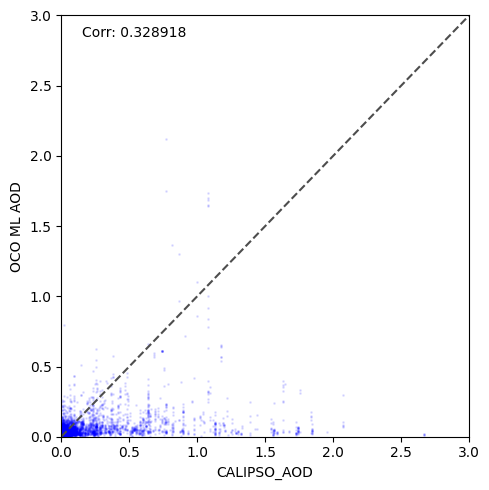

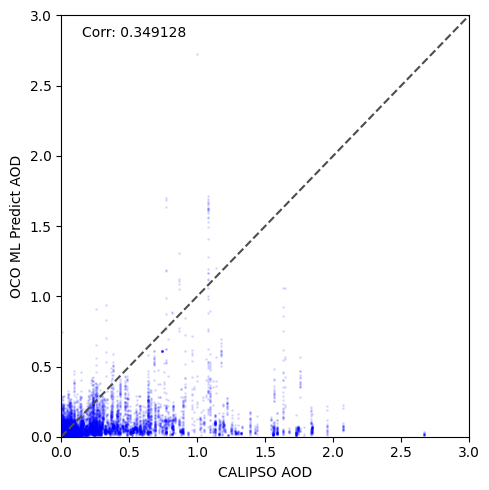

In [7]:
def plot_scatter(
    X,
    Y,
    dataset_name,
    feature_name,
    x_label=None,
    y_label=None,
    x_log=True,
    y_log=True,
):
    import matplotlib.pyplot as plt
    
    nan_mask = np.logical_or(np.isnan(X), np.isnan(Y))
    X = X[~nan_mask]
    Y = Y[~nan_mask]

    if x_log:
        X = np.exp(X)
    if y_log:
        Y = np.exp(Y)
    # print(Y.min(), Y.max())

    if x_label is None:
        x_label = f"CALIPSO {feature_name}"
    if y_label is None:
        y_label = f"OCO ML Predict {feature_name}"

    LIMIT = 3.0
    plt.figure(figsize=(5, 5))
    plt.scatter(X, Y, s=1, c="b", alpha=0.1)
    plt.plot([0, 10], [0, 10], ls="--", c=".3")
    # calc and plot correlation coefficient
    mask = np.logical_and(X > 0, Y > 0)
    corr = np.corrcoef(X[mask], Y[mask])[0, 1]
    plt.text(0.05, 0.95, f"Corr: {corr:.6f}", transform=plt.gca().transAxes)

    lim = min(LIMIT, max(X.max(), Y.max()))
    plt.xlim(0, min(LIMIT, lim))
    plt.ylim(0, min(LIMIT, lim))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.savefig(f"{dataset_name}_{feature_name}.png")

plot_scatter(y_test_calipso, pred, "CALIPSO", "AOD", x_label="CALIPSO_AOD", y_label="OCO ML AOD")

train_pred = model.predict(X_train).flatten()

plot_scatter(y_train_calipso, train_pred, "CALIPSO_train", "AOD")